In [49]:
import keras
import pickle
import random
import numpy as np
import pandas as pd
import re
import multiprocessing
import os
import seaborn as sns

from tqdm import *
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Reshape, concatenate, Flatten, Activation, LSTM, Dropout, Lambda
from keras.utils import np_utils

In [6]:
##### CONFIGURATION SETUP ####
data_path = "../logs/bpic2011.xes"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
target_variable = "concept:name"
### CONFIGURATION SETUP END ###

In [7]:
def load_trace_dataset(purpose='categorical', ttype='test'):
    suffix = "_{0}_{1}.pickled".format(purpose, ttype)
    p = data_path.replace(".xes", suffix)
    return pickle.load(open(p, "rb"))

In [8]:
train_traces = load_trace_dataset('categorical', 'train')
train_targets = load_trace_dataset('target', 'train')
test_traces = load_trace_dataset('categorical', 'test')
test_targets = load_trace_dataset('target', 'test')
feature_dict = load_trace_dataset('mapping', 'dict')

## Model creation

In [11]:
def schedule_lr(epoch):
    if epoch >= 25:
        return .75

In [274]:
batch_size = 1 # None translates to unknown batch size
# [samples, time steps, features]
il = Input(batch_shape=(batch_size,None,1))
main_output = Embedding(624, 500)(il)
main_output = Reshape(target_shape=(-1,500))(main_output) # reshape layer does not need to know BATCH SIZE!!!

# sizes should be multiple of 32 since it trains faster due to np.float32
main_output = LSTM(500,
                   batch_input_shape=(batch_size,None,1),
                   stateful=False,
                   return_sequences=True,
                   unroll=False,
                   kernel_initializer=keras.initializers.Zeros())(main_output)
main_output = LSTM(500,
                   stateful=False,
                   return_sequences=True,
                   unroll=False,
                   kernel_initializer=keras.initializers.Zeros())(main_output)

main_output = Dense(len(feature_dict["concept:name"]["to_int"]), activation='softmax', name='dense_final')(main_output)

full_model = Model(inputs=[il], outputs=[main_output])
optimizerator = keras.optimizers.SGD(lr=1)

full_model.compile(loss='categorical_crossentropy', optimizer=optimizerator, metrics=['categorical_accuracy', 'mae'])

## Data preparation

In [254]:
train_input_batches  = np.array([ t[target_variable].values.reshape((-1,1)) for t in train_traces ])
train_target_batches = np.array([ t.values.reshape((-1,625)) for t in train_targets])

## Model training

In [275]:
n_epochs = 2
for epoch in range(1,n_epochs+1):
        mean_tr_acc  = []
        mean_tr_loss = []
        mean_tr_mae  = []
        
        for t_idx in tqdm(range(0, 1), desc="Epoch {0}/{1}".format(epoch,n_epochs)):
            batch_x = train_input_batches[t_idx].reshape((1,-1,1))
            batch_y = train_target_batches[t_idx].reshape((1,-1,625))
            
            tr_loss, tr_acc, tr_mae = full_model.train_on_batch(batch_x, batch_y)
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
            mean_tr_mae.append(tr_mae)

        if epoch == 25: # why? See Implementation in evermann2016
            keras.backend.set_value(full_model.optimizer.decay, .75)
#         mean_tr_acc = round(np.mean(mean_tr_acc),3)
#         print('Epoch {0} -- loss = {1:.5f} -- acc = {2:.5f}'.format(epoch,np.mean(mean_tr_loss), mean_tr_acc))

Epoch 1/2: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


0.0


Epoch 2/2: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

0.75


## Model testing

In [4]:
full_model = keras.models.load_model("../models/evermann_baseline_e27_acc18.500.h5")

In [9]:
test_input_batches  = np.array([ t[target_variable].values.reshape((-1,1)) for t in test_traces ])
test_target_batches = np.array([ t.values.reshape((-1,625)) for t in test_targets])

## Percentile-dependent precision?

In [62]:
percentile_steps = 10
percentile_matches  = [0] * percentile_steps
percentile_elements = [0] * percentile_steps
n_total_tests = sum([len(t) for t in test_input_batches])

for x,y in zip(test_input_batches, test_target_batches):
    y_hat = full_model.predict(x.reshape((1,-1,1)))[0]
    current_percentile = 1
    percentile_step = len(x) / percentile_steps
    
    # loop through predicted next steps and compare
    for i in range(0,len(y)):
        if i > (current_percentile * percentile_step):
            current_percentile += 1
            
        # infer one-hot encoding and check if a prediction has been made correctly
        if np.argmax(y_hat[i]) == np.argmax(y[i]):
             # 0-based indexing, this is actually the 1st percentile
            percentile_matches[current_percentile -1] += 1
        percentile_elements[current_percentile -1] += 1
            
percentile_precisions = [p_m / p_t for p_m,p_t in zip(percentile_matches,percentile_elements)]

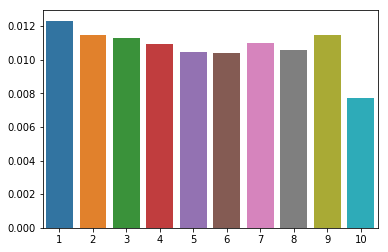

In [60]:
sns.barplot(x=list(range(1,percentile_steps+1)), y=percentile_precisions)

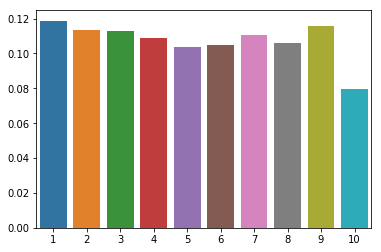

In [63]:
sns.barplot(x=list(range(1,percentile_steps+1)), y=percentile_precisions)